# 決定木の実装

## 評価関数

### 主要な決定木の評価関数

- 回帰
    - 平均二乗誤差
    - 平均絶対誤差
- 判別
    - エントロピー
    - ジニ係数

### エントロピーについて

確率をpとして
$$H = -p \log_2(p)$$
ただし、$p=0$のときには$H=0$とする。

決定木の場合、全クラスについて和を取った
$$H = \sum_{k=1}^C -p_k \log_2(p_k)$$
が用いられる。  
ただし$C$はクラスの種類の和であり、$p_k$はクラス$k$をとる確率である。  

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

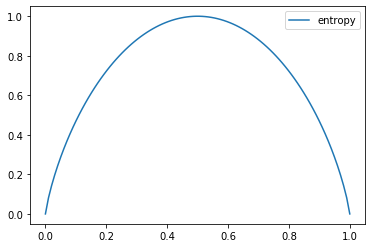

In [7]:
# 2クラスの場合
x_list = np.linspace(0,1,100)
entropy = lambda p: - p * np.log2(p) if p > 0 else 0
plt.plot(x_list, [entropy(p) + entropy(1-p) for p in x_list], label="entropy")
plt.legend();

確率が0.5(どちらのクラスに分類されるか分からない)場合に最もエントロピーが高くなることが分かる。  
また、完全に分類できる場合(1または0の場合)には、最もエントロピーが低くなっていることが分かる。  
このエントロピーを損失関数として使用すれば、スパッと分類できる場合には損失関数が減ることになる。  
(実際には、各グループのサンプル数で重み付けした値が損失関数となるので、なるべく大きいサイズのグループをスパッと分類できる場合に、損失関数が減ることになる。1個だけの極小のグループがきれいに分類できて、残りの大きなグループがあまり分類できなければ、損失関数は大して減少しない)

### ジニ係数について

確率をpとして
$$G = 1 - 2 p^2$$

決定木の場合、全クラスについて和を取った
$$H = \sum_{k=1}^C \left( 1 - 2 p_k^2 \right)$$
が用いられる。  
ただし$C$はクラスの種類の和であり、$p_k$はクラス$k$をとる確率である。  

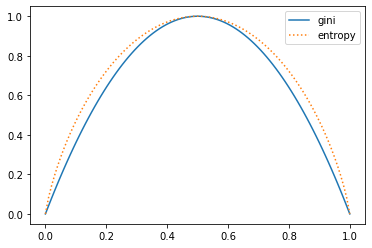

In [8]:
# 2クラスの場合
x_list = np.linspace(0,1,100)
gini = lambda p: 1 - 2 * p**2
plt.plot(x_list, [gini(p) + gini(1-p) for p in x_list], label="gini")
plt.plot(x_list, [entropy(p) + entropy(1-p) for p in x_list], ":", label="entropy")
plt.legend();

エントロピーと同様の傾向を示すことが分かる。  
少しの違いではあるが、0.2または0.8などのやや分類できている局面で、ジニ係数はより大きく減少することがわかる。

## 決定木の実装例

### メモ

In [9]:
class Test:
    def calc(self, x, y): return self._add(x,y)
    
    def _add(self, x, y):return x+y

In [10]:
test = Test()

In [11]:
test.calc(1,2)

3

In [12]:
raise ValueError("unknown!")

ValueError: unknown!

In [13]:
hasattr(1, "__call__")

False

In [14]:
import numpy as np

In [15]:
np.unique([3,2,1])

array([1, 2, 3])

In [16]:
type("mse")

str

In [17]:
type("mse") == "str"

False

In [18]:
np.repeat(np.array([1,2,3]).reshape(-1,1), 10, axis=-1)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])

### 実装

In [75]:
class DecisionTree:
    def __init__(self, loss_func="mse", minimum_gain=0, pred_func=None,
                 max_depth=None, current_depth=0, categories=None):
        self.loss_func, self.pred_func = self._check_loss_func(loss_func, pred_func)
        self.minimum_gain = minimum_gain
        self.current_depth = current_depth
        self.max_depth = max_depth
        self.best_var_idx, self.best_thresh = None, None
        self.categories = categories
    
    def fit(self, X, y, is_category_cols=None):    
        self.y_pred = self.pred_func(y)
        self.is_category_cols = is_category_cols
        if self.max_depth is None or self.current_depth < self.max_depth:
            loss_before = self.loss_func(y, self.y_pred)
            best_loss_gain = 0
            for i in range(X.shape[1]):
                is_cat = self.is_category_cols[i] if not self.is_category_cols is None else False
                    
                for thresh in np.unique(X[:,i])[1:-1]:
                    X_1, y_1, X_2, y_2 = self._split(X, y, i, thresh, is_cat)
                    y_pred_1 = self.pred_func(y_1)
                    y_pred_2 = self.pred_func(y_2)
                    loss_after = (len(y_1) * self.loss_func(y_1, y_pred_1) 
                                   + len(y_2) * self.loss_func(y_2, y_pred_2)) / len(y)
                    loss_gain = loss_before - loss_after
                    if loss_gain > self.minimum_gain and loss_gain > best_loss_gain:
                        self.best_var_idx = i
                        self.best_thresh = thresh
                        best_loss_gain = loss_gain
            if not self.best_thresh is None:
                is_cat = self.is_category_cols[self.best_var_idx] \
                            if not self.is_category_cols is None else False
                X_1, y_1, X_2, y_2 = self._split(X, y, self.best_var_idx,
                                                 self.best_thresh, is_cat)
                self.tree_1 = DecisionTree(self.loss_func, self.minimum_gain, 
                                               self.pred_func, self.max_depth, 
                                               self.current_depth+1, self.categories)
                self.tree_2 = DecisionTree(self.loss_func, self.minimum_gain, 
                                             self.pred_func, self.max_depth, 
                                             self.current_depth+1, self.categories)
                self.tree_1.fit(X_1, y_1)
                self.tree_2.fit(X_2, y_2)

    def predict(self, X):
        if self.best_thresh is None:
            res_y = np.repeat(self.y_pred.reshape(-1,1), X.shape[0], axis=-1).T
        else:
            y_cols = len(self.categories) if not self.categories is None else 1
            res_y = np.zeros((X.shape[0],y_cols))
            mask_1 = X[:,self.best_var_idx] <= self.best_thresh
            res_y[mask_1,:] = self.tree_1.predict(X[mask_1])
            res_y[~mask_1,:] = self.tree_2.predict(X[~mask_1])
        return res_y

    def _check_loss_func(self, loss_func, pred_func=None):
        if isinstance(loss_func, str):
            if loss_func.lower() == "mse":
                checked_loss_func = self._mse
                checked_pred_func = np.mean
            elif loss_func.lower() == "mae":
                checked_loss_func = self._mae
                checked_pred_func = np.median
            elif loss_func.lower() == "entropy":
                checked_loss_func = self._entropy
                checked_pred_func = self._p_category
            elif loss_func.lower() == "gini":
                checked_loss_func = self._gini
                checked_pred_func = self._p_category
            else:
                raise ValueError(f"Function '{loss_func}' hasn't been implemented!")
        elif hasattr(loss_func, "__call__"):
            if not pred_func is None:
                checked_loss_func = loss_func
                checked_pred_func = pred_func
            else:
                raise ValueError("For specifying function as loss_func,"
                                 + "predict_func is also needed.")
        else:
            raise ValueError("Invalid loss function!")
        return checked_loss_func, checked_pred_func
    
    def _mse(self, y, y_pred): return np.mean((y - y_pred)**2)
    
    def _mae(self, y, y_pred): return np.mean(np.abs((y - y_pred)))
    
    def _p_category(self, y):
        if self.categories is None:
            self.categories = np.unique(y)
        return np.array([np.sum(y==cat) for cat in self.categories]) / len(y)            
    
    def _entropy(self, y, y_pred):
        return np.sum([p * -np.log2(p) if p > 0 else 0 for p in y_pred])
    
    def _gini(self, y, y_pred):
        return 1 - np.sum([p**2 for p in y_pred])
    
    def _split(self, X, y, idx, thresh, is_cat=False):
        if is_cat:
            mask = X[:,idx] == thresh
        else:
            mask = X[:,idx] <= thresh
        X_1, y_1 = X[mask], y[mask]
        X_2, y_2 = X[~mask], y[~mask]
        return X_1, y_1, X_2, y_2

### 利用例) 回帰

#### ダミーデータ

In [76]:
tree = DecisionTree(max_depth=3, loss_func=lambda y, y_pred: np.mean((y - y_pred)**2),
                  pred_func=np.mean)

In [77]:
X = np.random.normal(size=(100,1))
y = X * 1.5

In [78]:
tree.fit(X, y.ravel())

In [79]:
tree.predict(X)[:5]

array([[1.11239725],
       [1.96837238],
       [1.96837238],
       [3.34219693],
       [1.11239725]])

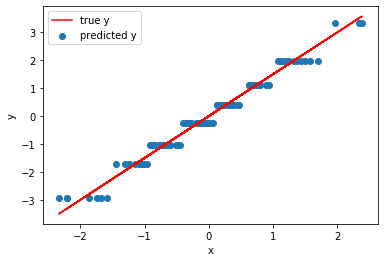

In [80]:
plt.scatter(X, tree.predict(X), label="predicted y")
plt.plot(X, y, "r", label="true y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

#### サンプルデータ

In [89]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()

boston_X = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_y = pd.Series(boston.target)

boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(boston_X, boston_y)

In [90]:
tree_boston = DecisionTree(max_depth=3)
tree_boston.fit(boston_X_train.values, boston_y_train.values)

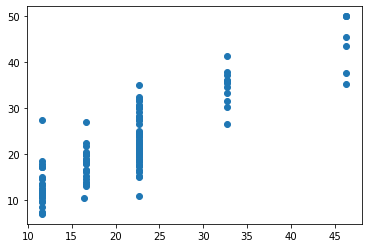

In [91]:
boston_y_pred = tree_boston.predict(boston_X_test.values)
plt.scatter(boston_y_pred, boston_y_test)

### 利用例) 判別

#### ダミーデータ

In [63]:
X = np.arange(1,101).reshape(-1,1)
y_wave = np.sin(X/ (2 * np.pi)) + np.random.normal(size=(100,1)) * 0.1
y_class = np.sign(y_wave)

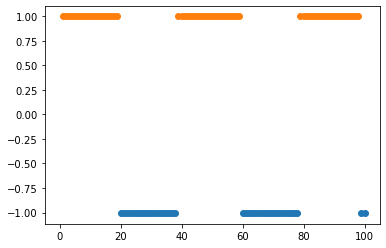

In [64]:
for cat in np.unique(y_class):
    mask = (y_class == cat)
    plt.scatter(X[mask], y_class[mask], label=f"true y class: {cat}")

In [65]:
y_wave[:5]

array([[0.038195  ],
       [0.2188312 ],
       [0.32347908],
       [0.48671207],
       [0.75285777]])

In [66]:
y_class[:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [67]:
tree_classifier = DecisionTree(max_depth=2, 
                               loss_func="entropy")

In [68]:
tree_classifier.fit(X, y_class)

In [69]:
tree_classifier.predict(X)[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [70]:
tree_classifier.predict(X).argmax(axis=1)[:5]

array([1, 1, 1, 1, 1])

In [71]:
tree_classifier.categories

array([-1.,  1.])

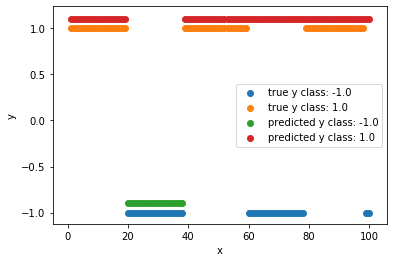

In [72]:
for cat in np.unique(y_class):
    mask = (y_class == cat)
    plt.scatter(X[mask], y_class[mask], label=f"true y class: {cat}")

y_class_pred = tree_classifier.predict(X).argmax(axis=-1)
for i, cat in enumerate(tree_classifier.categories):
    mask = (y_class_pred == i)
    plt.scatter(X[mask], np.repeat(cat+0.1, sum(mask)), label=f"predicted y class: {cat}",)
    
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

ジニ係数を用いた場合も同様である。

In [53]:
tree_classifier_gini = DecisionTree(max_depth=2, 
                               loss_func="gini")

In [54]:
tree_classifier_gini.fit(X, y_class)

In [55]:
tree_classifier_gini.predict(X)[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [56]:
tree_classifier_gini.predict(X).argmax(axis=1)[:5]

array([1, 1, 1, 1, 1])

In [57]:
tree_classifier_gini.categories

array([-1.,  1.])

#### サンプルデータ

In [92]:
from sklearn.datasets import load_iris
iris = load_iris()

iris_X = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_y = pd.Series(iris.target)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y)

In [86]:
tree_iris = DecisionTree(max_depth=3, loss_func="entropy")

In [93]:
tree_iris.fit(iris_X_train.values, iris_y_train.values)

In [94]:
iris_y_pred_class = tree_iris.predict(iris_X_test.values).argmax(axis=1)

In [95]:
np.mean(iris_y_pred_class == iris_y_test)

0.9473684210526315

## ランダムフォレストの分断の様子